# Imports and setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('drive/My Drive/Dogs Project')
gdrive_path = os.getcwd()

In [3]:
# update google colab to the latest version of fastai
!pip install -Uqq fastai

     |████████████████████████████████| 194kB 13.0MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 


In [4]:
!pip install PyGithub

     |████████████████████████████████| 296kB 12.2MB/s 


In [5]:
import os
import shutil
from datetime import datetime
import numpy as np
import pandas as pd
import tarfile
from io import BytesIO
from base64 import b64encode
from github import Github
from IPython.display import Markdown, display

# according to fastai book, use the star import notation despite python best practices
from fastai.vision.all import *
from fastai.vision.widgets import *

In [ ]:
SEED = 42

def set_seed(seed, dls=None, use_cuda=True):
    # For reproducibility. Run before any fits.
    # see 1: https://github.com/fastai/fastai/issues/2832 and
    # and 2: https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/28
    np.random.seed(seed) # cpu vars
    torch.manual_seed(seed) # cpu  vars
    random.seed(seed) # Python

    if dls is not None:  # DataLoaders object
        dls.rng.seed(seed)

    if use_cuda: # GPU
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
VALID_PCT = 0.2
TEST_PCT = 0.1
IMAGE_SIZE = 128

# Download, organize, and import data

In [ ]:
# remove pre-downloaded files if necessary

try:
    shutil.rmtree('/root/.fastai')
except FileNotFoundError:
    pass

In [ ]:
# this function is necessary because the tar file does not have .tgz extension
def extract_tar(fname, destparent):
    tarfile.open(fname).extractall(destparent)

# download and extract Stanford dogs dataset
download_path = untar_data('http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar', extract_func=extract_tar)

In [ ]:
# rename folders to be just the dog breed name
# e.g., change "n02109047-Great_Dane" to "Great Dane"

for path in download_path.ls():
    old_folder = os.path.basename(path)
    new_folder = old_folder[10:].replace('_', ' ').title()  # replace underscore with space, then proper case
    path.rename(download_path / new_folder)

download_path.ls()

(#120) [Path('/root/.fastai/data/images/Bedlington Terrier'),Path('/root/.fastai/data/images/Chesapeake Bay Retriever'),Path('/root/.fastai/data/images/Miniature Schnauzer'),Path('/root/.fastai/data/images/Irish Setter'),Path('/root/.fastai/data/images/Weimaraner'),Path('/root/.fastai/data/images/Brabancon Griffon'),Path('/root/.fastai/data/images/Malinois'),Path('/root/.fastai/data/images/Chihuahua'),Path('/root/.fastai/data/images/Boxer'),Path('/root/.fastai/data/images/Rottweiler')...]

## Make test set

In [ ]:
# Create a separate test set that is invisible to fastai. I had concerns that fastai was memorizing 
# the training set, as it gave > 99% accuracy on images from the training set, but low accuracy
# on new images (e.g., classifying a dingo image as a whippet).

set_seed(SEED)
for path in download_path.ls():
    files = list(get_image_files(path))
    test_count = int(len(files) * TEST_PCT)
    test_files = list(np.random.choice(files, size=test_count, replace=False))

    new_path = str(path).replace('images', 'test_images')
    print(new_path)
    os.makedirs(new_path, exist_ok=True)
    for test_file in test_files:
        test_file.rename(os.path.join(new_path, os.path.basename(test_file)))

    print(f'Moved {test_count} from {str(path)} to {new_path}')

/root/.fastai/data/test_images/Bedlington Terrier
Moved 18 from /root/.fastai/data/images/Bedlington Terrier to /root/.fastai/data/test_images/Bedlington Terrier
/root/.fastai/data/test_images/Chesapeake Bay Retriever
Moved 16 from /root/.fastai/data/images/Chesapeake Bay Retriever to /root/.fastai/data/test_images/Chesapeake Bay Retriever
/root/.fastai/data/test_images/Miniature Schnauzer
Moved 15 from /root/.fastai/data/images/Miniature Schnauzer to /root/.fastai/data/test_images/Miniature Schnauzer
/root/.fastai/data/test_images/Irish Setter
Moved 15 from /root/.fastai/data/images/Irish Setter to /root/.fastai/data/test_images/Irish Setter
/root/.fastai/data/test_images/Weimaraner
Moved 16 from /root/.fastai/data/images/Weimaraner to /root/.fastai/data/test_images/Weimaraner
/root/.fastai/data/test_images/Brabancon Griffon
Moved 15 from /root/.fastai/data/images/Brabancon Griffon to /root/.fastai/data/test_images/Brabancon Griffon
/root/.fastai/data/test_images/Malinois
Moved 15 fro

In [ ]:
# check that there are no images overlapping between /images/ and /test_images/
# show all images in both sets
dog = 'Miniature Pinscher'
train_imgs = [str(x) for x in (Path('/root/.fastai/data/images')/dog).ls()]
test_imgs = [str(x) for x in (Path('/root/.fastai/data/test_images')/dog).ls()]
print([x for x in test_imgs if x in train_imgs])

[]


## Make training + validation sets

Note: we want to split our data in a stratified way so that we don't have imbalanced classes. We will do this by making a dataframe containing all of the images, then randomly choose 20% of each class to be in the validation set.

In [ ]:
dat = []

set_seed(SEED)
for path in download_path.ls():  # for each dog breed
    tmp_files = [str(x) for x in get_image_files(path)]

    val_count = int(len(tmp_files) * VALID_PCT)
    val_files = list(np.random.choice(tmp_files, size=val_count, replace=False))
    train_files = [x for x in tmp_files if x not in val_files]

    # [path, label, is_valid]
    dat.extend([[parent_label(file) + '/' + os.path.basename(file), 
                 parent_label(file), 
                 False] for file in train_files])
    dat.extend([[parent_label(file) + '/' + os.path.basename(file), 
                 parent_label(file), 
                 True] for file in val_files])

df = pd.DataFrame(dat, columns=['file', 'label', 'is_valid'])
df.head()

file               label  is_valid
0  Bedlington Terrier/n02093647_3192.jpg  Bedlington Terrier     False
1  Bedlington Terrier/n02093647_2951.jpg  Bedlington Terrier     False
2  Bedlington Terrier/n02093647_2420.jpg  Bedlington Terrier     False
3   Bedlington Terrier/n02093647_239.jpg  Bedlington Terrier     False
4   Bedlington Terrier/n02093647_768.jpg  Bedlington Terrier     False

In [ ]:
# check that we've stratified correctly
df.groupby(['label']).agg({'is_valid':lambda x: sum(x == True) / len(x)}).reset_index()

label  is_valid
0                     Affenpinscher  0.200000
1                      Afghan Hound  0.199074
2               African Hunting Dog  0.196078
3                          Airedale  0.197802
4    American Staffordshire Terrier  0.195946
..                              ...       ...
115          Welsh Springer Spaniel  0.200000
116     West Highland White Terrier  0.196078
117                         Whippet  0.195266
118         Wire-Haired Fox Terrier  0.197183
119               Yorkshire Terrier  0.195946

[120 rows x 2 columns]

In [ ]:
# Note: we resize all images to the same size, padding with 0s (black) if the aspect ratio of
# the original image isn't right. We also augment batches to include transformed versions of our 
# images in each batch during training (rotation, flipping, perspective warping, brightness, and contrast).
# We do this on an entire batch at once instead of on an individual image basis because all images
# will be the same size by the time the batch is running.

dls = ImageDataLoaders.from_df(df,
    path='/root/.fastai/data/images',
    seed=SEED,
    fn_col=0,
    label_col=1,
    valid_col=2,
    y_block=CategoryBlock,
    item_tfms=Resize(IMAGE_SIZE, ResizeMethod.Pad, pad_mode='zeros'))

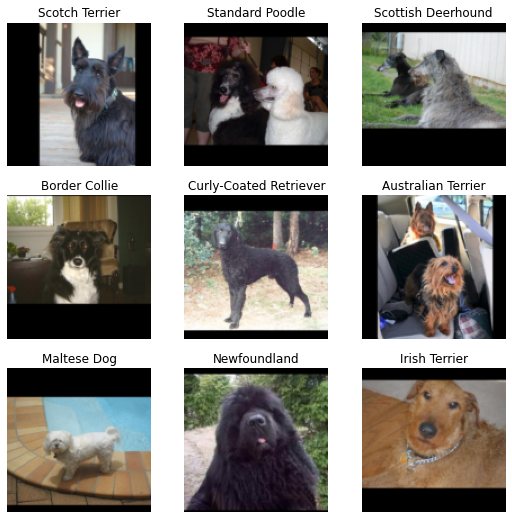

In [ ]:
dls.train.show_batch()

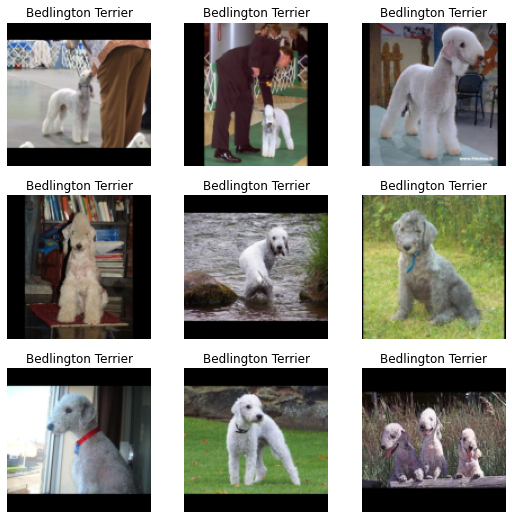

In [ ]:
# good! we have data in the validation set
dls.valid.show_batch()

# Model training & interpretation

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


(0.005754399299621582, 0.009120108559727669)


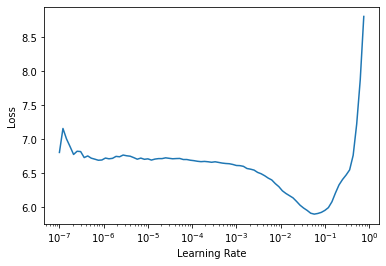

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)

set_seed(SEED, dls=dls)
lr_min, lr_steep = learn.lr_find()
print((lr_min, lr_steep))

In [ ]:
# 3 epochs with ResNet layers frozen, training new layers
# 10 additional epochs with the ResNet unfrozen, training all layers

set_seed(SEED)
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(epochs=20, freeze_epochs=3, base_lr=lr_steep)

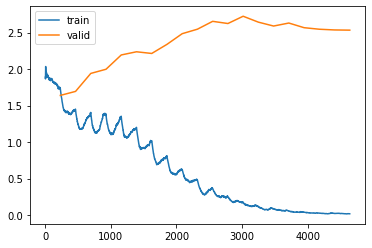

In [ ]:
learn.recorder.plot_loss()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

# Instead of showing confusion matrix (which would be 120x120, since we have 120 dog breeds),
# get counts of the breeds that were most confused for one another
interp.most_confused(min_val=5)

[('Entlebucher', 'Appenzeller', 10),
 ('Siberian Husky', 'Malamute', 10),
 ('Shih-Tzu', 'Lhasa', 9),
 ('English Foxhound', 'Walker Hound', 8),
 ('Miniature Poodle', 'Toy Poodle', 8),
 ('Shetland Sheepdog', 'Collie', 8),
 ('Toy Poodle', 'Miniature Poodle', 8),
 ('Walker Hound', 'English Foxhound', 8),
 ('Appenzeller', 'Entlebucher', 7),
 ('Black-And-Tan Coonhound', 'Gordon Setter', 7),
 ('Collie', 'Border Collie', 7),
 ('Eskimo Dog', 'Siberian Husky', 7),
 ('Irish Wolfhound', 'Scottish Deerhound', 7),
 ('Cardigan', 'Pembroke', 6),
 ('Malamute', 'Eskimo Dog', 6),
 ('Miniature Schnauzer', 'Standard Schnauzer', 6),
 ('Cairn', 'Norwich Terrier', 5),
 ('Collie', 'Shetland Sheepdog', 5),
 ('Doberman', 'Miniature Pinscher', 5),
 ('Entlebucher', 'Bernese Mountain Dog', 5),
 ('Redbone', 'Bloodhound', 5)]

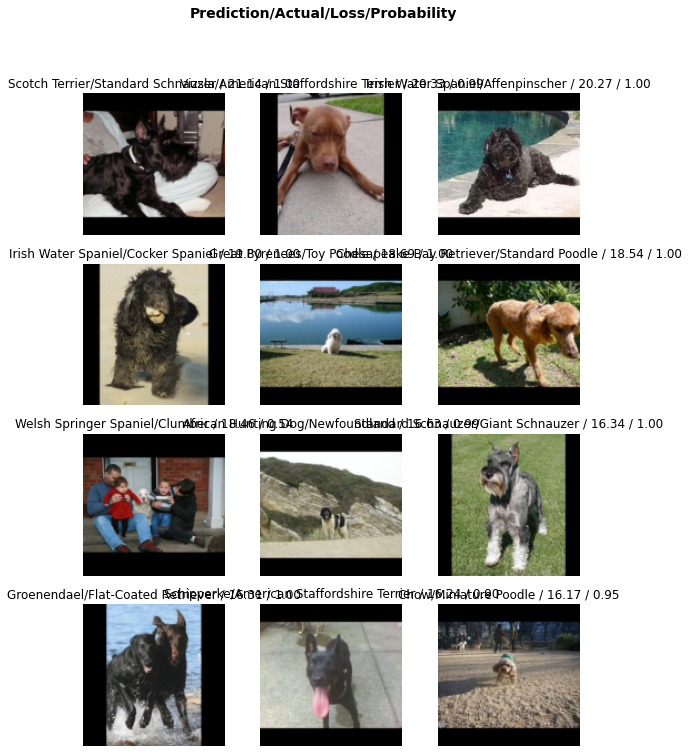

In [ ]:
# show the images with the highest losses in our dataset
# titles are: (prediction, actual, loss, and probability)
interp.plot_top_losses(12, nrows=4)

In [ ]:
# save our model
learn.export(os.path.join(gdrive_path, "dogs_simple_resnet18_fastai_{}.pkl".format(datetime.now().strftime("%Y%m%d_%H%M%S"))))

In [ ]:
# to save model to be used on a machine without access to NVidia GPUs:
learn.model = learn.model.cpu()
learn.export(os.path.join(gdrive_path, "dogs_simple_resnet18_fastai_cpu_{}.pkl".format(datetime.now().strftime("%Y%m%d_%H%M%S"))))

# Evaluate on test set

In [ ]:
test_images = get_image_files('/root/.fastai/data/test_images')
test_true_y = [parent_label(x) for x in test_images]
test_dl = learn.dls.test_dl(test_images)

probs, _, preds = learn.get_preds(dl=test_dl, with_decoded=True)
test_pred_y = [learn.dls.vocab[x] for x in preds.numpy()]

# test set accuracy
test_acc = sum([y0 == y1 for y0, y1 in zip(test_true_y, test_pred_y)]) / len(test_images)
print(f'Test set accuracy: {test_acc:.4f}')

Test set accuracy: 0.5376


In [ ]:
# double-check: look at the first 5 and last 5
[test_true_y[:5], test_pred_y[:5],
 test_true_y[-5:], test_pred_y[-5:]]

[['Bedlington Terrier',
  'Bedlington Terrier',
  'Bedlington Terrier',
  'Bedlington Terrier',
  'Bedlington Terrier'],
 ['Bedlington Terrier',
  'Bedlington Terrier',
  'Bedlington Terrier',
  'Bedlington Terrier',
  'Wire-Haired Fox Terrier'],
 ['Siberian Husky',
  'Siberian Husky',
  'Siberian Husky',
  'Siberian Husky',
  'Siberian Husky'],
 ['Eskimo Dog',
  'Siberian Husky',
  'Eskimo Dog',
  'Eskimo Dog',
  'German Shepherd']]

# Classify dogs I know

In [6]:
# assuming we are running this in a subsequent session, so we have to reload the learner
learn = load_learner("dogs_simple_resnet18_fastai_20210104_225053.pkl")

## Upload one image at a time, using widgets

Note: widgets do not appear in nbviewer, and so results don't show up in GitHub

In [ ]:
btn_upload = widgets.FileUpload()
btn_run = widgets.Button(description='Classify')
output_html = widgets.HTML()

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])

    # get the top 6 predictions, then extract the top one so we have top 5 AFTER the best one
    pred, pred_idx, probs = learn.predict(img)
    top5_preds = sorted(list(zip(learn.dls.vocab, list(probs.numpy()))), key=lambda x: x[1], reverse=True)[:6]
    top_pred = top5_preds.pop(0)

    # resize the image to have a maximum height of 200 pixels, then encode to base 64
    b = BytesIO()
    new_height = 200
    new_width = int((new_height / img.height) * img.width)
    img = img.resize((new_width, new_height))
    img.save(b, format='png')
    img_base64 = "<img height='200' src='data:image/png;base64,{}'/>".format(b64encode(b.getvalue()).decode('utf-8'))
    
    # update the html to include (1) the new image, base 64 encoded; (2) the top prediction and the
    # next 5 best; and (3) the previous outputs, if any
    output_html.value = img_base64 + "<br>" + \
        f'<b>Best guess: <u>{top_pred[0]}</u> (confidence: {100*top_pred[1]:.02f}%)</b><br>' + \
        "Next best:" + \
        "<ul>" + ''.join([f'<li>{x[0]} ({100*x[1]:.02f}%)</li>' for x in top5_preds]) + "</ul>" + \
        "\n\n<hr>\n" + output_html.value

btn_run.on_click(on_click_classify)

vb = VBox([widgets.Label('Upload an image of a dog'), 
      btn_upload, 
      btn_run, 
      output_html])

vb

## Classify images in directory on GitHub

In [7]:
# get GitHub access token
with open('key.key', 'r') as f:
    g = Github(f.read())

In [8]:
# list all images
repo = g.get_repo("willjobs/dog-classifier")
dog_images = repo.get_contents("dog_images")
dog_images = [img.download_url for img in dog_images if img.download_url[-2:] != "md"]  # exclude readme
dog_images

['https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_000.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_001.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_002.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_003.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_004.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_005.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_006.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_007.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_008.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_009.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File

In [9]:
# allows us to include markdown formatting in our print statements
def printmd(string):
    display(Markdown(string))

Processing File_000.jpeg...


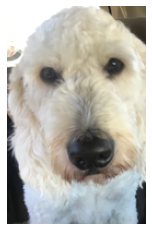

**Best guess: Sealyham Terrier (confidence: 77.14%)**

Next best:

* Old English Sheepdog (10.25%)
* Bedlington Terrier (4.32%)
* Airedale (3.59%)
* Wire-Haired Fox Terrier (1.50%)
* Kuvasz (0.79%)

---

Processing File_001.jpeg...


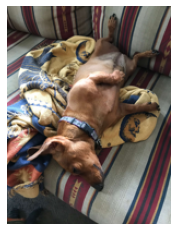

**Best guess: Chihuahua (confidence: 85.92%)**

Next best:

* Italian Greyhound (8.10%)
* Miniature Pinscher (5.74%)
* Doberman (0.14%)
* Weimaraner (0.03%)
* Norfolk Terrier (0.03%)

---

Processing File_002.jpeg...


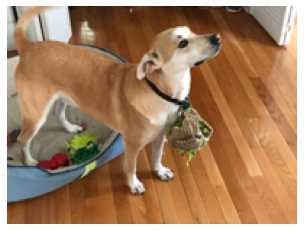

**Best guess: Basenji (confidence: 99.03%)**

Next best:

* English Foxhound (0.30%)
* Redbone (0.27%)
* Italian Greyhound (0.16%)
* Whippet (0.10%)
* Beagle (0.05%)

---

Processing File_003.jpeg...


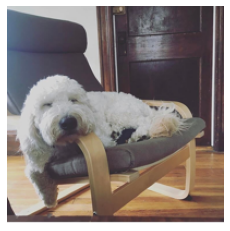

**Best guess: Bedlington Terrier (confidence: 56.77%)**

Next best:

* Old English Sheepdog (27.51%)
* Kuvasz (10.37%)
* Maltese Dog (2.05%)
* West Highland White Terrier (1.12%)
* English Setter (0.67%)

---

Processing File_004.jpeg...


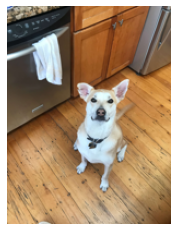

**Best guess: Pembroke (confidence: 99.99%)**

Next best:

* Basenji (0.01%)
* Ibizan Hound (0.00%)
* Chihuahua (0.00%)
* Dingo (0.00%)
* Cardigan (0.00%)

---

Processing File_005.jpeg...


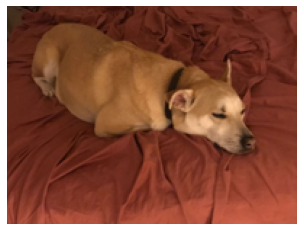

**Best guess: American Staffordshire Terrier (confidence: 95.88%)**

Next best:

* Staffordshire Bullterrier (1.09%)
* Basenji (0.90%)
* Rhodesian Ridgeback (0.85%)
* English Foxhound (0.64%)
* Boxer (0.11%)

---

Processing File_006.jpeg...


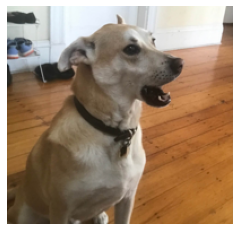

**Best guess: Great Dane (confidence: 80.54%)**

Next best:

* Rhodesian Ridgeback (8.76%)
* American Staffordshire Terrier (2.21%)
* Bull Mastiff (1.76%)
* Boxer (1.46%)
* Weimaraner (1.07%)

---

Processing File_007.jpeg...


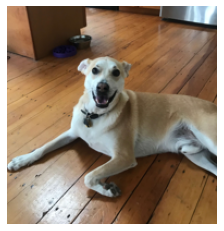

**Best guess: Staffordshire Bullterrier (confidence: 56.78%)**

Next best:

* American Staffordshire Terrier (25.95%)
* Boxer (3.38%)
* Lakeland Terrier (2.88%)
* Italian Greyhound (2.87%)
* Chihuahua (1.95%)

---

Processing File_008.jpeg...


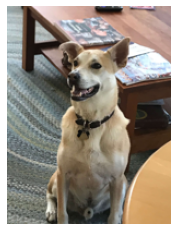

**Best guess: Chihuahua (confidence: 44.56%)**

Next best:

* Great Dane (28.36%)
* Malinois (14.34%)
* Kelpie (4.27%)
* Italian Greyhound (2.95%)
* Eskimo Dog (1.84%)

---

Processing File_009.jpeg...


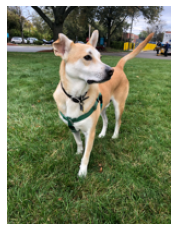

**Best guess: Dingo (confidence: 59.49%)**

Next best:

* Kelpie (26.16%)
* Basenji (12.36%)
* Toy Terrier (0.66%)
* Chihuahua (0.58%)
* Miniature Pinscher (0.46%)

---

Processing File_010.jpeg...


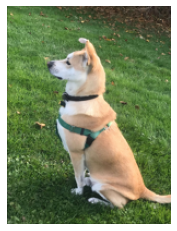

**Best guess: Basenji (confidence: 94.49%)**

Next best:

* Dingo (2.65%)
* Pembroke (1.90%)
* Redbone (0.51%)
* Beagle (0.14%)
* Italian Greyhound (0.13%)

---

Processing File_011.jpeg...


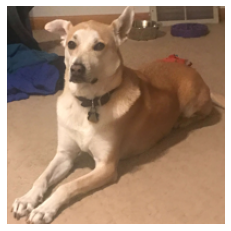

**Best guess: Staffordshire Bullterrier (confidence: 97.28%)**

Next best:

* Italian Greyhound (0.95%)
* Chihuahua (0.58%)
* American Staffordshire Terrier (0.47%)
* Mexican Hairless (0.18%)
* Schipperke (0.16%)

---

Processing File_012.jpeg...


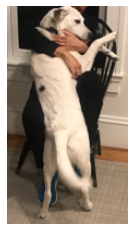

**Best guess: Great Dane (confidence: 85.41%)**

Next best:

* Kuvasz (4.08%)
* Bull Mastiff (2.99%)
* Irish Wolfhound (2.75%)
* Borzoi (2.70%)
* Pug (1.06%)

---

Processing File_013.jpeg...


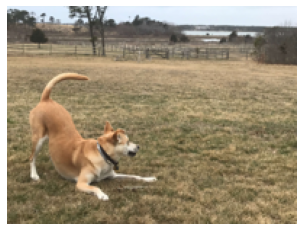

**Best guess: Pembroke (confidence: 38.33%)**

Next best:

* Basenji (31.89%)
* Dingo (11.38%)
* Collie (7.91%)
* Golden Retriever (7.19%)
* Cardigan (2.17%)

---

Processing File_014.jpeg...


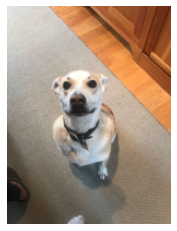

**Best guess: Beagle (confidence: 35.64%)**

Next best:

* Toy Poodle (18.21%)
* Pembroke (12.00%)
* Chihuahua (5.96%)
* Norfolk Terrier (5.76%)
* Italian Greyhound (4.20%)

---

Processing File_015.jpeg...


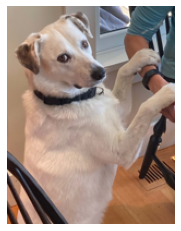

**Best guess: Labrador Retriever (confidence: 45.39%)**

Next best:

* Samoyed (35.62%)
* Great Pyrenees (3.19%)
* Siberian Husky (2.31%)
* Rhodesian Ridgeback (2.19%)
* Maltese Dog (2.18%)

---

Processing File_016.jpeg...


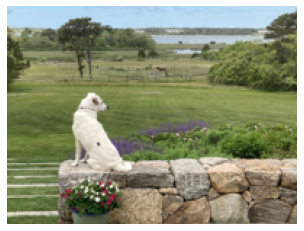

**Best guess: Great Pyrenees (confidence: 70.39%)**

Next best:

* Sealyham Terrier (16.88%)
* Komondor (2.72%)
* Tibetan Terrier (2.22%)
* Kuvasz (1.98%)
* Appenzeller (1.23%)

---

Processing File_017.jpeg...


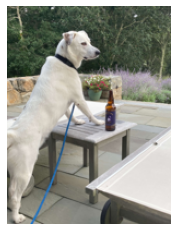

**Best guess: Great Pyrenees (confidence: 30.57%)**

Next best:

* Borzoi (20.23%)
* Wire-Haired Fox Terrier (6.66%)
* Walker Hound (5.97%)
* Kuvasz (5.72%)
* English Setter (4.29%)

---

Processing File_018.jpeg...


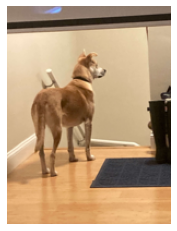

**Best guess: Italian Greyhound (confidence: 77.60%)**

Next best:

* Dingo (5.60%)
* Whippet (2.70%)
* Rhodesian Ridgeback (1.22%)
* Miniature Pinscher (1.21%)
* Norfolk Terrier (1.15%)

---

Processing File_019.jpeg...


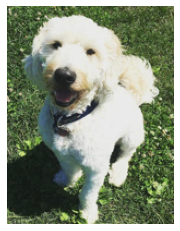

**Best guess: Kuvasz (confidence: 88.47%)**

Next best:

* Old English Sheepdog (10.12%)
* Tibetan Mastiff (0.48%)
* Komondor (0.45%)
* Miniature Poodle (0.14%)
* Bedlington Terrier (0.09%)

---

Processing File_020.jpeg...


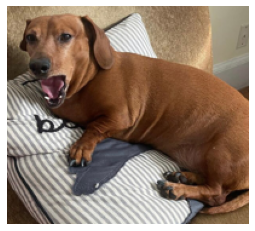

**Best guess: Vizsla (confidence: 82.22%)**

Next best:

* Chesapeake Bay Retriever (10.85%)
* Bloodhound (3.99%)
* Redbone (2.43%)
* Bull Mastiff (0.18%)
* Weimaraner (0.12%)

---

Processing File_021.jpeg...


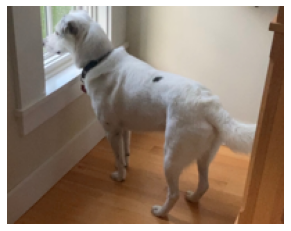

**Best guess: Great Pyrenees (confidence: 81.31%)**

Next best:

* Maltese Dog (4.52%)
* English Setter (3.45%)
* Sealyham Terrier (3.09%)
* Weimaraner (1.30%)
* Labrador Retriever (0.96%)

---

Processing File_022.jpeg...


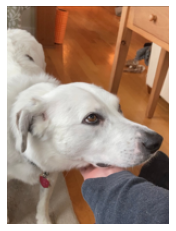

**Best guess: Chesapeake Bay Retriever (confidence: 32.87%)**

Next best:

* Weimaraner (23.71%)
* Whippet (21.45%)
* American Staffordshire Terrier (19.37%)
* Greater Swiss Mountain Dog (0.58%)
* Great Pyrenees (0.54%)

---

In [10]:
for url in dog_images:
    print(f"Processing {os.path.basename(url)}...")

    # must use PILImage.create, not Image.open, otherwise fastai doesn't work
    img = PILImage.create(requests.get(url, stream=True).raw)

    # get the top 6 predictions, then extract the top one so we have top 5 AFTER the best one
    pred, pred_idx, probs = learn.predict(img)
    top5_preds = sorted(list(zip(learn.dls.vocab, list(probs.numpy()))), key=lambda x: x[1], reverse=True)[:6]
    top_pred = top5_preds.pop(0)

    # output (1) the image (resized)
    #        (2) the top prediction
    #        (3) the next 5 best
    
    outstr = f"**Best guess: {top_pred[0]} (confidence: {100*top_pred[1]:.02f}%)**\n\n" + \
        "Next best:\n\n" + \
        '* ' + '\n* '.join([f'{x[0]} ({100*x[1]:.02f}%)' for x in top5_preds]) + \
        "\n\n---"

    plt.imshow(img.to_thumb(h=200))
    plt.axis('off')
    plt.show(block=False)  # forces plots to show immediately, interspersed with text, not at the end

    printmd(outstr)